In [40]:
recession1_years = [ '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007']
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

drop_columns = ['industry_code',  'own_code',  'size_code',  'disclosure_code',  'industry_title',  'own_title',  'size_title',  'lq_disclosure_code',  'oty_disclosure_code',  'oty_month1_emplvl_chg',  'oty_month2_emplvl_chg',  'oty_month3_emplvl_chg',  'oty_total_qtrly_wages_chg',  'oty_taxable_qtrly_wages_chg',  'oty_qtrly_contributions_chg',  'oty_avg_wkly_wage_chg',  'lq_qtrly_estabs_count',  'lq_month1_emplvl',  'lq_month2_emplvl',  'lq_month3_emplvl',  'lq_total_qtrly_wages',  'lq_taxable_qtrly_wages',  'lq_qtrly_contributions',  'oty_qtrly_estabs_count_chg',  'oty_qtrly_estabs_count_pct_chg',  'oty_month1_emplvl_pct',  'oty_month2_emplvl_pct',  'oty_month3_emplvl_pct',  'oty_total_qtrly_wages_pct',  'oty_taxable_qtrly_wages_chg',  'oty_qtrly_contributions_pct',  'oty_avg_wkly_wage_pct',  'oty_taxable_qtrly_wages_chg.1',  'lq_avg_wkly_wage',  'taxable_qtrly_wages',  'qtrly_contributions']

schema_dict = { 'area_fips':str,  'own_code':str,  'industry_code':str,  'agglvl_code':str,  'size_code':str,  'year':int,  'qtr':int,  'disclosure_code':str,  'area_title':str,  'own_title':str,  'industry_title':str,  'agglvl_title':str,  'size_title':str,  'qtrly_estabs':int,  'month1_emplvl':int,  'month2_emplvl':int,  'month3_emplvl':int,  'total_qtrly_wages':int,  'taxable_qtrly_wages':int,  'qtrly_contributions':int,  'avg_wkly_wage':int,  'lq_disclosure_code':str,  'lq_qtrly_estabs':float,  'lq_month1_emplvl':float,  'lq_month1_emplv2':float,  'lq_month1_emplv3':float,  'lq_total_qtrly_wages':float,  'lq_taxable_qtrly_wages':float,  'lq_qrtly_contributions':float,  'oty_disclosure_code':str,  'oty_qtrly_estabs':int,  'oty_qtrly_estabs_pct_chg':float,  'oty_month1_emplvl_chg':int,  'oty_month1_emplvl_pct_chg':float,  'oty_month2_emplv_chg':int,  'oty_month2_emplvl_pct_chg':float,  'oty_month3_emplvl_chg':int,  'oty_month3_emplvl_pct_chg':float,  'oty_total_qtrly_wages_chg':int,  'oty_total_qtrly_wages_pct_chg':float,  'oty_taxable_qtrly_wages_chg':int,  'oty_taxable_qtrly_wages_pct_chg':float,  'oty_qrtly_contributions_chg':int,  'oty_qrtly_contributions_pct_chg':float,  'oty_avg_wkly_wage_chg':int,  'oty_avg_wkly_wage_pct_chg':float}   

In [2]:
#This file takes the quarterly raw data from the QCEW and turns them into quarterly timelines. From here, we can compute target variables.

def add_qtrid(df):
    '''
    adds a column for the year and quarter.

    params: df(dataframe)
    returns: dataframe with column added'''
    df['qtrid'] = df['year'] + (df['qtr']/4)
    return df

def import_one(year):
    '''brings a single year's woth of data into a dataframe. Used for initial EDA. 
    Referenced in import_all

    params: year(str)
    returns: df(dataframe)'''
    filepath =  str(year) + '.csv'
    #all relevant csvs are renamed with only the year
    df = pd.read_csv(filepath, dtype = schema_dict)
    #schema_dict is found in dictionaries.py
    for column in drop_columns:
        if column in df.columns:
            df = df.drop([column], axis = 1)
    return df

def import_all(years):
    '''combines as many years ofdata into a single dataframe, as well as adding quater id
    References import_one and add_qtrid

    params: years (list of str)
    returns: df (dataframe)'''
    df = import_one(years[0])
    for year in years[1:]:
        df = df.append(import_one(year))
    df = add_qtrid(df)
    return df


def third_quarter(index):
    '''imports only every 3rd quarter row- required to import entire dataset (too large)
    Referenced in feature_space

    params: index, int
    returns: boolean'''
    if index == 0:
        return False
    elif (index - 3) % 4 == 0:
        return False
    else:
        return True

In [3]:
### Help functions for target calculation ###

def calc_nadir(s):
    assert isinstance(s, pd.Series)
    return s.min()

def calc_nadir_qtr(s):
    return s.argmin()

def calc_pre_peak(s):
    return s[ : s.argmin()].max()

def calc_pre_peak_quarter(s):
    try:
        qtr = s[ : s.argmin()].argmax()
    except:
        qtr = None
    return qtr

def calc_post_peak(s):
    return s[s.argmin() : ].max()

def calc_post_peak_qtr(s):
    return s[s.argmin() : ].argmax() + s.argmin()

In [26]:
def create_timeline_2001(variable):
    '''produces a timeline dataframe(and exports to json) for 2001

    params: variable, str, one of ['month3_emplvel' (employment), 'avg_wkly_wage' (wages)]
    returns: df, Dataframe'''
    
    df = import_all(recession1_years)
    df = df.pivot_table(columns = 'qtrid', values = variable, index = ['area_fips', 'area_title'], aggfunc = np.sum)
    df = df.reset_index()
    #fill nans
    df = df.fillna(0)
    df2 = df.drop(columns = ['area_fips', 'area_title'])
    df2 = df2.reset_index()
    df2 = df2.drop(columns = 'index')
    df2 = df2.fillna(0)

    
#     #this specifies when the jobs numbers "bottom-out" during the recession
#     nadir = df2.iloc[:,6:].apply(lambda x: calc_nadir(x), axis=1).rename('nadir')
    
#     #counts the number of quarters to the nadir since the beginning of the timeframe
#     nadir_qtr = df2.iloc[:,6:].apply(lambda x: calc_nadir_qtr(x), axis=1).rename('nadir_qtr')
    
#     #computes the highest points before and after the nadir, and captures the quarter count
#     pre_peak = df2.apply(lambda x: calc_pre_peak(x), axis=1).rename('pre_peak')
#     pre_peak_qtr = df2.apply(lambda x: calc_pre_peak_quarter(x), axis=1).rename('pre_peak_qtr')
#     post_peak = df2.apply(lambda x: calc_post_peak(x), axis=1).rename('post_peak')
#     post_peak_qtr = df2.apply(lambda x: calc_post_peak_qtr(x), axis=1).rename('post_peak_qtr')
    

    df2['nadir'] = df2.iloc[:,6:].min(axis=1)
    df2['nadir_qtr'] = df2.iloc[:,6:].idxmin(axis=1).apply(lambda x: df.columns.get_loc(x))
    df2['new'] = [df2.iloc[i].values for i in df.index]
    df2['pre_peak'] = df2.apply(lambda x: max(x['new'][0:x['nadir_qtr']]), axis=1)
    df2['post_peak'] = df2.apply(lambda x: max(x['new'][x['nadir_qtr']:]), axis=1)
    df2['pre_peak_qtr'] = pd.Series([s[i] for i, s in zip(df2.index, df2['pre_peak'].apply(
        lambda x: [i for i in (df2.iloc[:,0:-6] == x)
                   .idxmax(axis=1)]))]).apply(lambda x: df2.columns.get_loc(x))
    df2['post_peak_qtr'] = pd.Series([s[i] for i, s in zip(df2.index, df2['post_peak'].apply(
        lambda x: [i for i in (df2.iloc[:,0:-6] == x)
                   .idxmax(axis=1)]))]).apply(lambda x: df2.columns.get_loc(x))
    df_new = df2[['nadir', 'nadir_qtr', 'pre_peak', 'pre_peak_qtr', 'post_peak', 'post_peak_qtr']]
    df_new
    
    #puts the computed points in a dataframe, joins with timeline
#     df_results = pd.concat([df['area_fips'], nadir, nadir_qtr, pre_peak, pre_peak_qtr, post_peak, post_peak_qtr], axis=1)
    df = df.join(df_new, how = 'outer', rsuffix = '_derive')
    
    #PRIMARY TARGET: did the area decline the entire time(-1), did it start growing again but not avhieve it's former numbers(0), or did it grow and recover(1)?
    df['recovery'] = (df['post_peak'] >= df['pre_peak']) *1

    #SECONDARY TARGET: How long did the jobs numbers decline?
    df['decline'] = (df['nadir_qtr'] - df['pre_peak_qtr'])
    
    #TERTIARY TARGET different in before/after jobs numbers
    df['delta'] = df['post_peak'] - df['pre_peak']
    
    #export the data
#     df.to_json('data/Recession1_timeline.json')
#     df = df.fillna(0)
    return df

In [30]:
df_2001 = create_timeline_2001('month3_emplvl')

In [31]:
 def plot(fips):
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize = (12,4))
    x = ['Q1 2000', 'Q2 2000', 'Q3 2000', 'Q4 2000', 'Q1 2001', 'Q2 2001', 'Q3 2001', 'Q4 2001',
         'Q1 2002', 'Q2 2002', 'Q3 2002', 'Q4 2002', 'Q1 2003', 'Q2 2003', 'Q3 2003', 'Q4 2003',
          'Q1 2004', 'Q2 2004', 'Q3 2004', 'Q4 2004', 'Q1 2005', 'Q2 2005', 'Q3 2005', 'Q4 2005',
           'Q1 2006', 'Q2 2006', 'Q3 2006', 'Q4 2006', 'Q1 2007', 'Q2 2007', 'Q3 2007', 'Q4 2007']
    y = df_2001.loc[fips][1:33]
    ax.plot(x,y, color = 'green', linewidth = 1, alpha = 0.8)
    ax.axhline(y = df_2001.loc[fips]['nadir'], xmin = 'Q1 2000', xmax = 'Q4 2007', 
                    color = 'red', linewidth = .5, alpha = 0.5, label = 'nadir')
    ax.axhline(y = df_2001.loc[fips]['pre_peak'], xmin = 'Q1 2000', xmax = 'Q4 2007',
                    color = 'blue', linewidth = .5, alpha = .5, label = 'pre-recession-peak')
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    ax.ticklabel_format(style = 'plain', axis = 'y', scilimits = (9, -1)) 
    ax.get_yaxis().set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.axvline(x = 'Q3 2001', color = 'black', linewidth = 0.5, alpha = 0.5, label = '09/11/2001)')
    ax.legend(fancybox = True, borderaxespad=0)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [38]:
df_2001 = df_2001.set_index('area_fips')

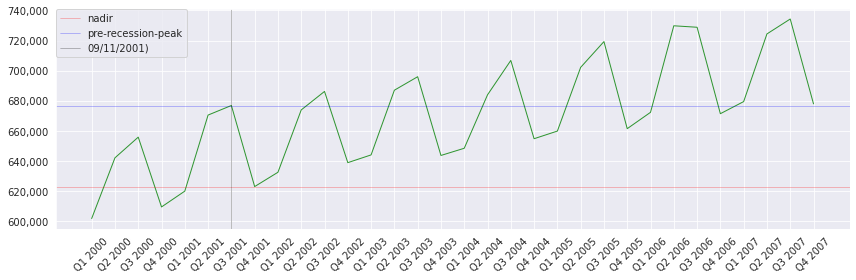

In [41]:
plot('02000')